# Convolutional Neural Networks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/tensorflow/04-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

Because pixels are spatially correlated, we want to incorporate this into the structure of our networks. In particular, we want to capture an abstract property of objects or features present in images called **spatial locality**. This means that a feature that is meaningful at a certain location should be equally meaningful for a model at another place in the image. And that discriminative features typically exist only on localized regions in an image (e.g. a dog nose or cat ears), so that looking at large regions of the image can confuse the model. Spatial locality is captured by **convolutional layers** that naturally results in capacity reduction by allowing the same weights to be applied to multiple input neurons.

In [1]:
import random
import warnings
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.datasets import cifar10


DATASET_DIR = Path("./data").absolute()

warnings.simplefilter(action="once")
backend_inline.set_matplotlib_formats('svg')

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Convolution operation

The following discussion follows from [this lecture](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN%27s.pdf) where the following image of a kitten is considered. Our task is to do linear classification using matrix multiplication. In previous notebooks, we classified images by flattening them into long vectors as inputs to vanilla neural networks. This is a bit unstatisfying since we are discarding important spatial information, e.g. we would get the same result if we add a preprocessing layer that permutes the pixels of input images to the model. Moreover, this method results in extremely matrices in order to produce multi-channel output images. In theory, such a model has overcapacity, and would be impossible to properly train. In practice, such a layer would be impossible to store and work with in memory.

```{figure} ../../img/cat-conv.png
---
width: 40em
---
Nearby pixels constitute meaningful features of images.
```

But notice that the two pixels indicated on the left image probably do not need to be mixed to figure out this is a cat. On the other hand, three nearby pixels on the right image can form a linear combination that can be useful for determining cat-like features. This means that pixels that are far away in the input have weights that cannot be nonzero at the same time. This results in a banded weight matrix.

Let $\boldsymbol{\mathsf X}$ be the input image and $\boldsymbol{\mathsf{S}}$ be the output feature map. Suppose ${\mathsf n}^2 = |\boldsymbol{\mathsf X}|$ and ${\mathsf m}^2 = |\boldsymbol{\mathsf{S}}|.$ Having a banded weight matrix reduces the size of the weight matrix from $\mathcal{O}(\mathsf{n}^2{\mathsf m}^2)$ to $\mathcal{O}(\mathsf k_h \mathsf k_w{\mathsf m}^2)$ where a local region of $\mathsf k_h \times \mathsf k_w$ pixels in the input are mixed. It makes sense to further constrain the weights in the local region to be equal througout the image since we want to capture translationally invariant features. This further reduces the number of weights to $\mathcal{O}(\mathsf k_h \mathsf k_w).$ The resulting linear operation is called a **convolution** written in two spatial dimensions as:

$$
\boldsymbol{\mathsf{S}} = (\boldsymbol{\mathsf X} \circledast \boldsymbol{\mathsf{K}})_{ij} = \sum_{x = 0}^{{\mathsf k_h}-1} \sum_{y=0}^{{\mathsf k_w}-1} {\boldsymbol{\mathsf X}}_{i + x, j + y} \, {\boldsymbol{\mathsf{K}}}_{xy}.
$$

Observe that spatial ordering of the pixels in the input $\boldsymbol{\mathsf X}$ is somehow preserved in the output $\boldsymbol{\mathsf{S}}.$ This is nice since we want to preserve spatial information across a stack of convolution operations.

```{margin}
Figure source:<br>
[`deepimaging.github.io`](https://deepimaging.github.io/lectures/lecture_9_intro_to_CNN's.pdf)
```
```{figure} ../../img/conv-cat-99.png
---
width: 30em
---
Banded Toeplitz matrix for classifying cats. The violet bars contain the same pixel values. For images, since we concatenate rows into a long vector, we will actually have multiple bands in the weight matrix.
```

### Convolutional layer

Replacing the dense operation with a convolution between the input and the weight tensors, we get the **convolutional layer** of a neural network. Note that we handle input and output channels as this allows for richer hidden representation, e.g. RGB images have three channels. The convolutional layer computes:

$$
\begin{aligned}
{\bar{\boldsymbol{\mathsf X}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1} ({\boldsymbol{\mathsf X}}_{[:,\, :,\, c]} \circledast {\boldsymbol{\mathsf K}}_{[:,\,:,\, c,\,{k}]})_{ij} \right) \\
&= \varphi\left({\boldsymbol{\mathsf u}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\boldsymbol{\mathsf X}}_{i + x,\, j + y,\, c} \, {\boldsymbol{\mathsf K}}_{xyc,{k}} \right) \\
\end{aligned}
$$

for $k = 0, \ldots, {\mathsf c}_\text{out}-1$. The input and output tensors have the same dimensionality and semantic structure which makes sense since we want to stack convolutional layers in modular fashion. The shape of the weight tensor is $({\mathsf k}_h, {\mathsf k}_w, {\mathsf c}_\text{in}, {\mathsf c}_\text{out}).$ Moreover, we think of resulting feature maps as themselves images that inherit the spatial structure of its inputs. We also see that the same weights are applied to differents parts of the image. This controls the number of parameters and makes sure that features that make sense at most places in the image are captured by the layer.

#### Kernel visualization

Observe that the computation in convolutional layers is analogous to computation dense layers: with units that process images instead of numbers. Here the number of output channels correspond to layer width or the number of features of the hidden representation. This can be visualized as follows.

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-03 05:21:09.205283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-03 05:21:09.205410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


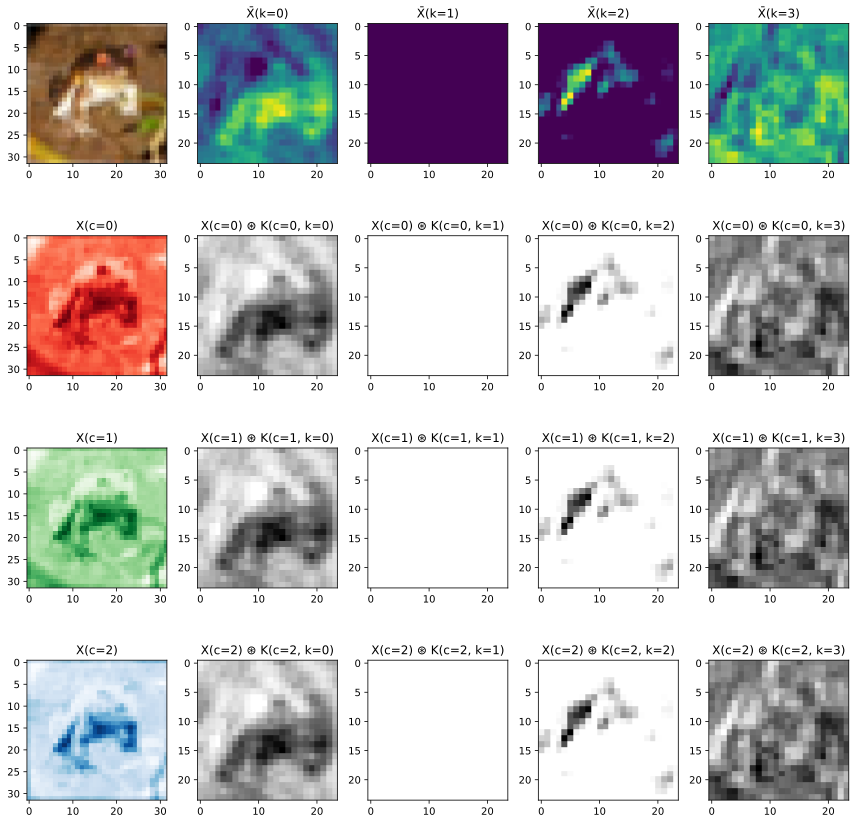

In [2]:
def visualize_conv_layer(*, X, conv):
    """Visualizing convolution kernels and output channels on a 3D image."""
    
    cmaps = ['Reds', 'Greens', 'Blues']

    # Get kernel weights
    conv.build(input_shape=X.shape)
    K = conv.get_weights()[0]

    c_in  = X.shape[-1]
    c_out = K.shape[-1]

    # Iterate over in channels
    fig, ax = plt.subplots(c_in+1, c_out+1, figsize=(12, 12))
    ax[0, 0].imshow(X[:, :, :])
    for c in range(c_in):
        ax[c+1, 0].set_title(f'X(c={c})')
        ax[c+1, 0].imshow(X[:, :, c], cmap=cmaps[c])

    # Iterate over kernel filters
    outs = {}
    for k in range(c_out):
        conv_k = kr.layers.Conv2D(filters=1, kernel_size=9, activation='relu')
        conv_k.build(input_shape=(32, 32, 3))
        T = conv_k.get_weights()
        T[0][:, :, :, 0] = K[:, :, :, k]
        conv_k.set_weights(T)
        for c in range(c_in):
            outs[(c, k)] = conv_k(X[None, :, :, :])[0, :, :, 0]
            ax[c+1, k+1].imshow(outs[(c, k)], cmap='Greys') 
            ax[c+1, k+1].set_title(f"X(c={c}) ⊛ K(c={c}, k={k})")

    # Iterate over out channels
    for k in range(c_out):
        ax[0, k+1].imshow(sum([outs[(c, k)] for c in range(c_in)]))
        ax[0, k+1].set_title(r"$\bar{\mathrm{X}}$" + f'(k={k})')

    fig.tight_layout()
    return outs


(X_train, y_train), _ = cifar10.load_data()
conv = kr.layers.Conv2D(filters=4,  kernel_size=9, activation='relu')
X = X_train[0] / 255. # Frog?
o = visualize_conv_layer(X=X, conv=conv)

Here we can see that the channels of convolutional layers are analogous to units of dense layers. Each kernel in entries `i, j > 0` combines column-wise with the inputs to compute `X(c=i) ⊛ K(c=i, k=j)`. The sum of these terms form the output map `X̅(k=j)` above. This looks like matrix multiplication which dense layers implement, but with convolutions between matrices, instead of products between numbers. 

#### Implementation

Here we check that the formula discussed above is the same formula implemented in the Keras `Conv2D` layer. Consistent with the above equation, this layer expects input images to have shape `(B, H, W, c)` for a batch input of size `B` of `H × W` images with `c` channels. This is also expected the shape of output of a convolutional layer.

Input shape:  (1, 32, 32, 3)
Output shape: (1, 24, 24, 4)
Kernel shape: (9, 9, 3, 4)
Bias shape:   (4,)
Mean absolute error = 5.817209e-08


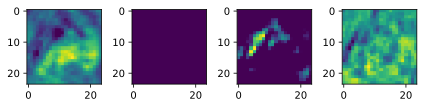

In [3]:
def conv2D(X, K, u, activation=None):
    """Implementing a 2D convolutional layer from scratch."""

    h, w = K.shape[:2]
    B, H0, W0, c_in = X.shape
    H1 = H0 - h + 1
    W1 = W0 - w + 1
    c_out = K.shape[3]

    S = np.zeros(shape=(B, H1, W1, c_out))

    for b in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[3]):
                    if activation is None:
                        f = lambda x: x
                    else:
                        f = activation

                    # Perform 3D convolution (h, w, c_in) for each out channel
                    S[b, i, j, k] = f(u[k] + (K[:, :, :, k] * X[b, i:i+h, j:j+w, :]).sum())
    return S


X = X_train[0][None, :, :, :] / 255.
K = conv.weights[0].numpy()
u = conv.weights[1].numpy()
S = conv2D(X, K, u, activation=lambda x: max(0, x))

print("Input shape: ", X.shape)   # (B, H_in,  W_in,  c_in)
print("Output shape:", S.shape)   # (B, H_out, W_out, c_out)
print("Kernel shape:", K.shape)   # (h, w, c_in, c_out)
print("Bias shape:  ", u.shape)   # (c_out,)

# Check if above formula agrees with TF implementation
print("Mean absolute error =", np.abs(S - conv(X)).mean())

# Plotting the images obtained using the above formula
fig, ax = plt.subplots(1, 4)
for j in range(4):
    ax[j].imshow(S[0, :, :, j])
fig.tight_layout()

Constructing the corresponding **Toeplitz matrix** of the operation:

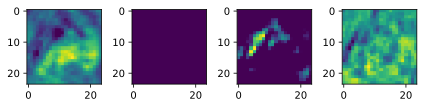

In [4]:
@np.vectorize
def np_relu(x):
    return max(x, 1e-16)

def output_shape(kernel, input_shape):
    h, w = kernel.shape[:2]
    B, H0, W0, c_in = input_shape
    H1, W1 = H0 - h + 1, W0 - w + 1
    c_out = kernel.shape[3]
    return B, H1, W1, c_out

def toeplitz(kernel, input_shape):
    """Constructing the Toeplitz matrix."""

    c_in = input_shape[3]
    c_out = kernel.shape[3]
    h, w  = kernel.shape[:2]
    H0, W0 = input_shape[1:3]
    B, H1, W1, c_out = output_shape(kernel, input_shape)
    
    T = np.zeros((H0 * W0, H1 * W1, c_in, c_out))
    for c in range(c_out):
        for k in range(c_in):
            for i in range(H1):
                for j in range(W1):
                    ii = i * W0 + j
                    jj = i * W1 + j
                    for hh in range(h):
                        T[ii + (hh * W0): ii + (hh * W0) + w, jj, k, c] = K[hh, :, k, c].reshape(-1)
    return T


# Constructing the output image
c_out = K.shape[3]
c_in  = X.shape[3]
B, H1, H2, c_out = output_shape(K, X.shape)

T = toeplitz(K, X.shape)

fig, ax = plt.subplots(1, 4)
for c in range(c_out):
    s = []
    for k in range(c_in):
        x = X[0, :, :, k].reshape(-1)
        s.append(x @ T[:, :, k, c])
    s = sum(s)
    ax[c].imshow(np_relu(s).reshape(24, 24))

fig.tight_layout()

Looks good! Toeplitz matrices for the first input channel:

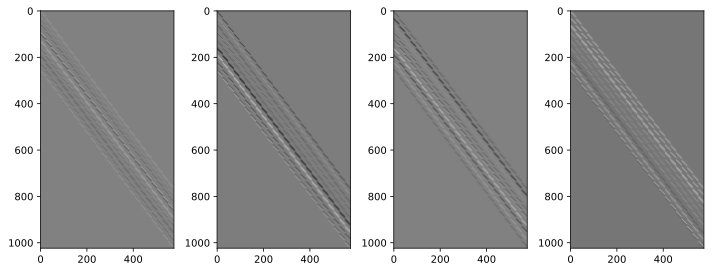

In [5]:
fig, ax = plt.subplots(1, c_out, figsize=(10, 6))
c = 0
for k in range(c_out):
    ax[k].imshow(T[:, :, c, k], cmap='gray');
plt.tight_layout()

Sparsity of the leftmost matrix above:

In [6]:
t = T[:, :, 0, 0]
(t != 0).sum() / t.size

0.0791015625

### Stride and padding

The above definition of convolution can be modified to include a parameter $s$ called the **stride** that controls the step size of the kernel when it slides over the input image. A convolution layer with stride $s$ computes:

$$
\begin{aligned}
{\bar {\boldsymbol{\mathsf{X}}}}_{ij,\, k} 
&= \varphi\left({\boldsymbol{\mathsf{u}}}_{k} + \sum_{c=0}^{{\mathsf c}_\text{in}-1}\sum_{x = 0}^{{\mathsf k}_h-1} \sum_{y=0}^{{\mathsf k}_w-1} {\boldsymbol{\mathsf{X}}}_{si + x,\, sj + y,\, c} \, {\boldsymbol{\mathsf{K}}}_{xyc,{k}} \right)
\end{aligned}
$$


for $k = 0, \ldots, {\mathsf c}_\text{out}-1.$ This includes the original definition which has a step size of 1. Note that strided convolutions can be thought of as a form of downsampling (discussed below) since it results in a significant reduction in image size. A larger stride along with a large kernel size can be useful if objects are large relative to the dimension of the image. For example, AlexNet {cite}`imagenet-paper` used large kernel size and large stride to capture relatively objects in its inputs.

<br>

```{figure} ../../img/imagenet.png
---
width: 45em
name: imagenet
---
Sample images from the ImageNet dataset {cite}`imagenet`. AlexNet used a kernel of size 11 × 11 with a stride of 4 in the first layer since objects in the [ImageNet dataset](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description) tend to occupy more pixels. 

```

**Padding.** Observe that in the above definition of convolution, the kernel placed entirely within the input image. This has the disadvantage of being biased towards the center pixels, resulting in information loss on the edges of the input image. Also notice that applying convolutions will always result in decreasing spatial dimension which limits the depth of the network. A simple fix is to simply pad the edges with zeros so the kernel can be placed over the edges:

(1, 38, 38, 3)


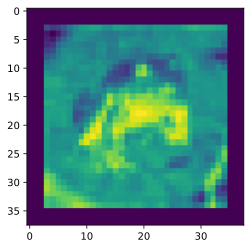

In [7]:
pad = kr.layers.ZeroPadding2D(padding=3)

print(pad(X).shape)
plt.imshow(pad(X)[0, :, :, 0]);

### Output size

The size of the output feature map is directly influenced by padding and stride. Suppose the input feature map has width $\mathsf{w}_\text{in}$ and let the kernel have width $\mathsf{f}$, then the output image has width 

$$\mathsf{w}_\text{out} = \left\lfloor \frac{\mathsf{w}_\text{in} + 2{p} - \mathsf{f}}{{s}} \right\rfloor + 1$$

assuming equal padding ${p}$ on both sides and a stride ${s}.$ Using convolution directly is not always desirable as some pixels of the input can be dropped because a kernel cannot be placed within the image to cover them following the set stride:


```bash
input    1 2 3 4 5 6 7 8 (9)
         ⌊_______⌋     ⁞ dropped
               ⌊_______⌋ 
```

For odd kernel size $\mathsf{f}$ and unit stride $s = 1$, we can use $2p = \mathsf{f} - 1$ to get same sized outputs and with the kernel covering the entire input in a symmetric manner. For this reason and for the sake of symmetry, [odd-sized kernels](https://datascience.stackexchange.com/a/23186) is generally preferred for convolutions.

```bash
input    0 0 1 2 3 4 5 6 7 8 9 0 0
         ⌊_______⌋ ⁞             ⁞
           ⌊_______⌋             ⁞
                    ...          ⁞
                         ⌊_______⌋
```

For strides $s > 1$, the best practice is to choose a kernel size $\mathsf{f}$ and the smallest padding $p$ such that $s$ divides $\mathsf{w}_\text{in} + 2p - \mathsf{f}$ so the entire input image is covered symmetrically by the kernel in constructing the convolved image.

```bash
input    0 1 2 3 4 5 6 7 8 9 0
         ⌊_______⌋     ⁞     ⁞
               ⌊_______⌋     ⁞
                     ⌊_______⌋
                         
```

<br>

**TF implementation.** The `padding` argument in convolutional layers in TensorFlow takes in either `"valid"` or `"same"`. The `"valid"` setting means that no padding is used an the kernel is placed only where it can be validly placed within the image. As discussed above this can result in discarding some pixels in the right as well as bottom part of the image. 

The `"same"` setting is a bit more confusing for $s > 1.$ Here the image is zero-padded as evenly as possible such that $\mathsf{w}_\text{out} = \lceil \mathsf{w}_\text{in} / s \rceil.$ In particular, $\mathsf{w}_\text{out} = \mathsf{w}_\text{in}$ whenever $s = 1$ with this setting, i.e. TF will choose $p = (\mathsf{f} - 1)/2.$ Note that this is the minimal padding that does not result in dropped pixels. But we can always use `ZeroPadding2D` before a convolution to specify zero padding count similar to PyTorch.

### Downsampling

For any unit of a hidden layer, its **receptive field** refers to all the units from all the previous layers that may affect the calculation of the unit during forward pass. In particular, units in the final classification layer should have a receptive field that contains the whole input image in the input layer. Otherwise, some parts of the input data will not improve the performance of the model for that class. 

```{margin}
**Figure 14.2** from {cite}`geron2019hands-on`
```
```{figure} ../../img/receptive_field.png
---
width: 35em
---
Receptive field of a pixel in the third layer of a convolutional network.
```

One way to increase receptive field is by **downsampling** which is defined as taking a sample, or aggregating samples, of pixels in the current layer so that we can pass a smaller input onto the next layer. This results in lower computational costs and a reduction in the capacity of the network which can be good. Downsampling is commonly done by means of a **pooling** operation.

```{margin}
Figure from: <br>
[`cs231n/conv-nets`](https://cs231n.github.io/convolutional-networks/)
```

### Pooling

A pooling layer operates like a convolutional layer in that we can set a stride, padding, and kernel size. But unlike the convolution operation, pooling is non-parameteric. **Max pooling** takes 
the maximum value in the region that is covered by its kernel. This layer provides invariance to small translations of the input at the cost of some information loss which can be desirable. Note that max pooling works well with the ReLU activation since all activation values subject to comparison are all nonnegative.

```{figure} ../../img/pooling-cs231n.png
---
---

Pooling layer downsamples the volume spatially independently in each channel. The input tensor of size 224 × 224 × 64 is pooled with filter size 2 and stride 2 into output volume of size 112 × 112 × 64. Notice that the volume depth is preserved, i.e. compresses but preserves concept. This operation is shown in the right.
```

[[5 9]
 [4 8]]


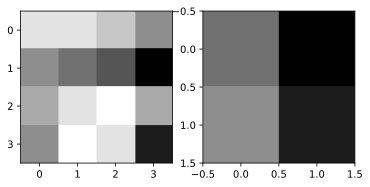

In [8]:
X = tf.convert_to_tensor([
    [ 1, 1, 2, 4],
    [ 4, 5, 6, 9],
    [ 3, 1, 0, 3],
    [ 4, 0, 1, 8]]
)[None, :, :, None]

pool = kr.layers.MaxPool2D(pool_size=2, strides=2)


plt.subplot(1, 2, 1)
plt.imshow(X.numpy()[0, :, :, 0], cmap='gray_r', vmin=0)

plt.subplot(1, 2, 2)
plt.imshow(pool(X).numpy().reshape(2, 2), cmap='gray_r', vmin=0)
print(pool(X).numpy().reshape(2, 2))

Note that pooling is applied to each channel separately, so that the number of output channels is maintained. This makes sense since we want only to compress the original input without affecting its semantic structure. 
In practice, there are two commonly used settings: `k = 2` and `s = 2` where the pooling regions are do not overlap, and the more aggressive overlapping pooling with `k = 3` and `s = 2`. Using larger kernel sizes can be too aggressive resulting in loss of discriminative information. This can be observed in the example below. 

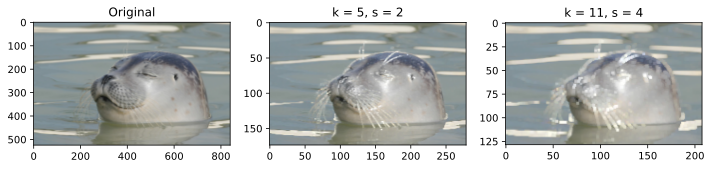

In [9]:
dog = DATASET_DIR / "dog.jpeg"
image_raw = tf.io.read_file(str(dog))
image = tf.image.decode_image(image_raw)[None, :, :, :]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image[0, :, :, :])
ax[0].set_title("Original")
ax[1].imshow(kr.layers.MaxPool2D(pool_size=5, strides=3)(image)[0, :, :, :])
ax[1].set_title("k = 5, s = 2")
ax[2].imshow(kr.layers.MaxPool2D(pool_size=11, strides=4)(image)[0, :, :, :])
ax[2].set_title("k = 11, s = 4");

## Implementing a convnet

In this section, we implement a **Convolutional Neural Network** (CNN) for classifying [FashionMNIST](https://keras.io/api/datasets/fashion_mnist/) {cite}`fashion-mnist` images using the Keras sequential API. This makes sense since a convnet is simply a stack of convolutional blocks, i.e. performing convolution, activation, and max-pooling, for feature extraction, followed by a dense classification subnetwork on the final extracted features. This section builds on Section 14.3 of {cite}`mlbook2022`.

Note that we will implement a network with a width of 512 in the last dense layer instead of 1024 indicated in the figure below. Significantly reducing the number of parameters of the model is nice for our small machine. Also, we add [Batch Normalization](https://arxiv.org/abs/1502.03167) {cite}`batchnorm` layers after convolutions and check whether this improves model performance. 

```{margin}
Figure source: <br>
[`github.com/rasbt/`](https://github.com/rasbt/machine-learning-book/blob/main/ch14/figures/14_12.png)
```
```{figure} ../../img/convnet.png
---
---
Visualizing the architecture of the network implemented below.

```

### Network architecture

Observe that the network follows the pattern of stacking `[Conv → ReLU → Pool]` blocks. This is typical in network design: using blocks composed of layers that together forms a basic functional unit. Here the spatial dimensions are downsampled while increasing the number of output channels, then the resulting long vector is passed to a dense classification subnetwork.

In [10]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same'),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPooling2D(pool_size=2, strides=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

For convolutional layers **width** corresponds to the number of filters for each convolutional layer. This corresponds to the number of channels of the 2-dimensional output feature maps. This is the 2-dimensional analog of hidden layers in dense networks where hidden layers output feature vectors that are interpreted as a representation of the input in another dimension. Increasing the number of filters directly increases the capacity of the network.

On the other hand, increasing the **depth** of the network correspond to higher level features, which can be thought of as more combinations of lower level features in the shallow layers of the network. Feature combination allows networks to learn patterns using less data points. Deeper networks is said to result in richer representations that generalize better. But the tradeoff is that these representations are generally more difficult to learn, e.g. due to vanishing gradients.

```{margin}
{cite}`imagenet-paper`
```
```{figure} ../../img/alexnet-weights.jpeg
---
---
Filters (11 × 11 × 3) in the first layer of AlexNet {cite}`imagenet-paper`. Note that these capture lower level features of images such as presence of horizontal edges or blobs of color.
```

### Training

In [11]:
from tensorflow.keras.datasets import fashion_mnist

def preprocess(data):
    data = data.reshape((-1, 28, 28, 1))
    data = data.astype('float32') / 255.
    return data 

# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

# Split train and validation sets
X_valid = X_train[:10000]
y_valid = y_train[:10000]
X_train = X_train[10000:]
y_train = y_train[10000:]


# Compile model with Adam and cross-entropy
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train model on FashionMNIST data
hist = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20


2022-09-01 19:01:33.263932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-01 19:01:33.549162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.5750 - accuracy: 0.8012

2022-09-01 19:01:48.342859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 17s 20ms/step - loss: 0.5750 - accuracy: 0.8012 - val_loss: 0.3411 - val_accuracy: 0.8734
Epoch 2/20
782/782 [==============================] - 16s 20ms/step - loss: 0.3640 - accuracy: 0.8698 - val_loss: 0.2818 - val_accuracy: 0.8956
Epoch 3/20
782/782 [==============================] - 17s 21ms/step - loss: 0.3092 - accuracy: 0.8889 - val_loss: 0.2774 - val_accuracy: 0.8954
Epoch 4/20
782/782 [==============================] - 17s 22ms/step - loss: 0.2767 - accuracy: 0.8994 - val_loss: 0.2691 - val_accuracy: 0.9010
Epoch 5/20
782/782 [==============================] - 17s 22ms/step - loss: 0.2514 - accuracy: 0.9088 - val_loss: 0.2273 - val_accuracy: 0.9165
Epoch 6/20
782/782 [==============================] - 20s 26ms/step - loss: 0.2290 - accuracy: 0.9152 - val_loss: 0.2164 - val_accuracy: 0.9211
Epoch 7/20
782/782 [==============================] - 18s 24ms/step - loss: 0.2111 - accuracy: 0.9242 - val_loss: 0.2142 - val_accuracy: 0.9180
Epo

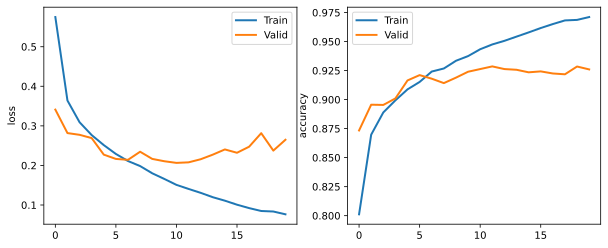

In [12]:
def plot_model_history(history, ax, metric='accuracy', label='', **kwargs):
    """Plotting result of Keras model training."""

    train_label = f'Train ({label})' if len(label) > 0 else 'Train'
    valid_label = f'Valid ({label})' if len(label) > 0 else 'Valid'
    ax[0].plot(history.history['loss'], label=train_label, color="C0", **kwargs)
    ax[0].plot(history.history['val_loss'], label=valid_label, color="C1", **kwargs)
    ax[0].set_ylabel('loss')
    ax[0].legend()

    ax[1].plot(history.history[metric], label=train_label, color="C0", **kwargs)
    ax[1].plot(history.history[f'val_{metric}'], label=valid_label, color="C1", **kwargs)
    ax[1].set_ylabel(metric)
    ax[1].legend()


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, linewidth=2)

In [13]:
print(f"Test accuracy: {model.evaluate(X_test, y_test)[1]}")

313/313 [==============================] - 4s 12ms/step - loss: 0.3007 - accuracy: 0.9215
Test accuracy: 0.921500027179718


In [14]:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

pred_proba = model.predict(X_test)
pred = np.argmax(pred_proba, axis=1)
pred_table = pd.DataFrame({
    'pred': pred, 
    'proba': [pred_proba[i, j] for (i, j) in enumerate(pred)], 
    'true': y_test.reshape(-1),
})

 20/313 [>.............................] - ETA: 1s

2022-09-01 19:08:28.007331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step


Plotting the examples where model is least confident in its prediction:

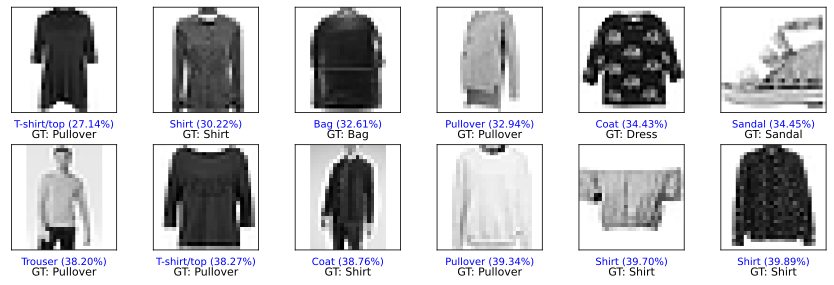

In [15]:
fig = plt.figure(figsize=(12, 4))
worst_preds = pred_table.sort_values('proba')[:12]

for i in range(12):
    img_index = worst_preds.index[i]
    image = X_test[img_index]
    row = worst_preds.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"{class_names[row['pred']]} ({row['proba']*100:.2f}%)", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

### Effect of Batch Normalization

Since we already have our experiment set up, might as well run some tests. Recall that we fitted batch normalization layers after the convolutional layers. Let us see how this affects model training.

In [16]:
model_no_bn = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
    kr.layers.MaxPooling2D(pool_size=2),
    
    kr.layers.Flatten(),
    kr.layers.Dense(512, activation='relu'),
    kr.layers.Dropout(rate=0.5),
    kr.layers.Dense(10, activation='softmax')
])


# Build and compile with Adam and cross-entropy
model_no_bn.build(input_shape=(None, 28, 28, 1))
model_no_bn.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train on FashionMNIST data
hist_no_bn = model_no_bn.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64,
    validation_data=(X_valid, y_valid)
)

Epoch 1/20


2022-09-01 19:08:31.184984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8317

2022-09-01 19:08:51.635214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 23s 28ms/step - loss: 0.4671 - accuracy: 0.8317 - val_loss: 0.3033 - val_accuracy: 0.8908
Epoch 2/20
782/782 [==============================] - 21s 27ms/step - loss: 0.2954 - accuracy: 0.8935 - val_loss: 0.2655 - val_accuracy: 0.9010
Epoch 3/20
782/782 [==============================] - 22s 28ms/step - loss: 0.2530 - accuracy: 0.9071 - val_loss: 0.2370 - val_accuracy: 0.9119
Epoch 4/20
782/782 [==============================] - 23s 30ms/step - loss: 0.2220 - accuracy: 0.9188 - val_loss: 0.2350 - val_accuracy: 0.9132
Epoch 5/20
782/782 [==============================] - 22s 28ms/step - loss: 0.1971 - accuracy: 0.9269 - val_loss: 0.2198 - val_accuracy: 0.9179
Epoch 6/20
782/782 [==============================] - 21s 27ms/step - loss: 0.1781 - accuracy: 0.9333 - val_loss: 0.2160 - val_accuracy: 0.9170
Epoch 7/20
782/782 [==============================] - 19s 24ms/step - loss: 0.1577 - accuracy: 0.9409 - val_loss: 0.2089 - val_accuracy: 0.9235
Epo

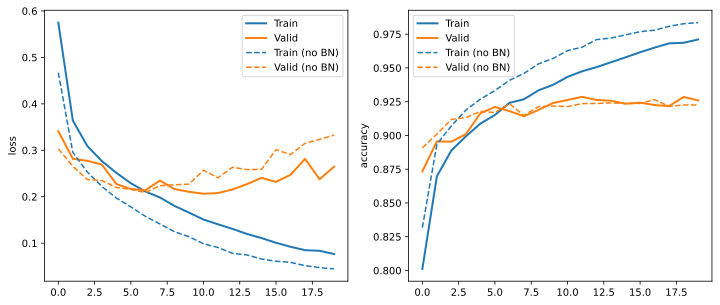

In [17]:
# Plot on same axis as prev model
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_model_history(history=hist, ax=ax, linewidth=2)
plot_model_history(history=hist_no_bn, ax=ax, label="no BN", linestyle="dashed")

Observe that the model with batch normalization exhibits less overfitting.

In [18]:
print(f"Test accuracy (BN):     {model.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy (w/o BN): {model_no_bn.evaluate(X_test, y_test, verbose=0)[1] * 100:.2f}%")

Test accuracy (BN):     92.15%
Test accuracy (w/o BN): 92.08%


## Data augmentation

In this section, we will create a convolutional network for classifying whether or not an image of a person is smiling or not. The dataset we will be using is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) {cite}`celeb_a` which contains 202,599 images of celebrities’ faces. In addition, 40 binary facial attributes are available for each image. This section builds on Section 14.4 of {cite}`mlbook2022`.

To speed up training we will use only a small subset of 16,000 faces. However, this is a small dataset. To increase the size of the dataset, and improve generalization, we will use **data augmentation**. This technique incorporates transformed versions of the original images into the dataset resulting in a model that is robust to changes that should not affect semantics such as rotation and translation.

```bash
USER="jessicali9530"
DATASET="celeba-dataset"
DATA_DIR=./data
mkdir ${DATA_DIR}
kaggle datasets download -d ${USER}/${DATASET} -p ${DATA_DIR}
unzip ${DATA_DIR}/${DATASET}.zip -d ${DATA_DIR}/${DATASET} > /dev/null
rm ${DATA_DIR}/${DATASET}.zip
```

```text
mkdir: ./data: File exists
Downloading celeba-dataset.zip to ./data
 100%|████████████████████████████████▉| 1.33G/1.33G [09:24<00:00, 3.13MB/s]
```

Plotting example images with their labels:

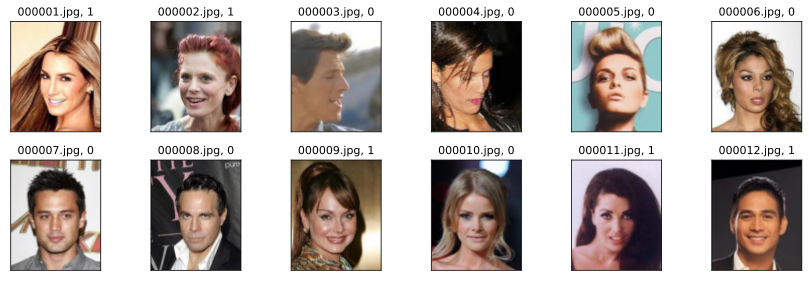

In [19]:
image_dir_path = DATASET_DIR / "celeba-dataset" / "img_align_celeba" / "img_align_celeba"
face_file_list = sorted([str(path) for path in image_dir_path.glob("*.jpg")])

# Get id -> target dictionary
dataset_path = DATASET_DIR / 'celeba-dataset'
attr = pd.read_csv(dataset_path / 'list_attr_celeba.csv')[['image_id', 'Smiling']]
attr['Smiling'] = attr['Smiling'].map({1: 1, -1: 0})
get_smile = dict(zip(attr.image_id, attr.Smiling))

# Plot examples from dataset
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_path = face_file_list[i]
    image_id = image_path.split('/')[-1]
    label = get_smile[image_id]
    image = plt.imread(image_path)

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.imshow(image)
    ax.set_title(f"{image_id}, {label}", fontsize=11)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

### Transformations

For the sake of demonstration, we apply various transformations on a single image. These are cropping to a bounding box, flipping horizontally, adjusting the contrast, adjusting the brightness, and  center-cropping and resizing the resulting image back to its original size of 218 × 178. All of these are available in the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) library.

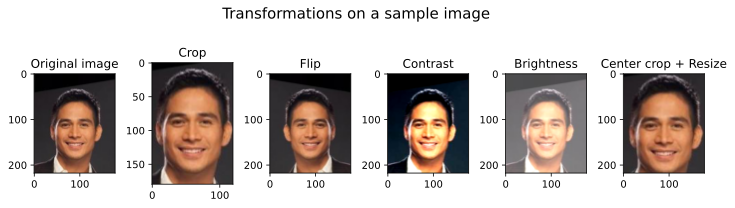

In [20]:
# Get sample image
image = plt.imread(face_file_list[11])

# Apply augmentations to sample image
cropped = tf.image.crop_to_bounding_box(image, 25, 30, 180, 120)
flipped = tf.image.flip_left_right(image)
contrast_adjusted = tf.image.adjust_contrast(image, 2.)
brightness_adjusted = tf.image.adjust_brightness(image, delta=0.3)
center_cropped = tf.image.central_crop(image, central_fraction=0.7)
resized_center_cropped = tf.image.resize(center_cropped, size=[218, 178]) / 255.

# Visualize
fig, ax = plt.subplots(1, 6, figsize=(10, 3))

ax[0].set_title("Original image")
ax[1].set_title("Crop")
ax[2].set_title("Flip")
ax[3].set_title("Contrast")
ax[4].set_title("Brightness")
ax[5].set_title("Center crop + Resize")

ax[0].imshow(image)
ax[1].imshow(cropped)
ax[2].imshow(flipped)
ax[3].imshow(contrast_adjusted)
ax[4].imshow(brightness_adjusted)
ax[5].imshow(resized_center_cropped)

fig.suptitle("Transformations on a sample image", fontsize=15)
fig.tight_layout()

Observe that the transformations above are all deterministic. The idea behind data augmentation is to inject randomness into these transformations to get new data points since these transformations do not change the label. For example, the parameters for contrast and brightness change can be drawn from some uniform distribution. 

For our training dataset we apply a sequence of transformation: first we perform random cropping so the model can focus more on the face, this is followed by a random horizontal flip, and a final resize to 64 × 64. For test data, we remove the stochasticity as we want to avoid unnecessary information loss.

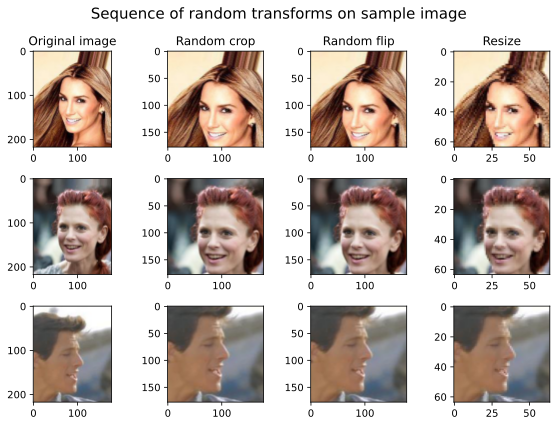

In [21]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))

ax[0, 0].set_title("Original image")
ax[0, 1].set_title("Random crop")
ax[0, 2].set_title("Random flip")
ax[0, 3].set_title("Resize")

for i, file_name in enumerate(face_file_list[:3]):
    image = plt.imread(file_name)
    ax[i, 0].imshow(image)
    image = tf.image.random_crop(image, size=(178, 178, 3))
    ax[i, 1].imshow(image)
    image = tf.image.random_flip_left_right(image)
    ax[i, 2].imshow(image)
    image = tf.image.resize(image, size=[64, 64]) / 255.
    ax[i, 3].imshow(image)
    
fig.suptitle("Sequence of random transforms on sample image", fontsize=15)
fig.tight_layout()

The 64x64 images in the last column are those that will make up the training data. In the next section, we will define a tranformation pipeline and simulate how three sample images are presented to the model across multiple epochs. 

Note that we prefer using exactly one transformed version of an image per epoch so that the model is not biased, in contrast to the alternative of using multiple transformations of a single image in one epoch. We also want to avoid cropping too aggressively, otherwise we might crop the mouth out of the image which is highly predictive of a smile.

### Creating the augmented dataset

We now load the JPEG files into a TensorFlow dataset and apply the transformation to get a `MapDataset`. The whole process was introduced in a [previous notebook](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/01-tensorflow-nn.html#dataset-from-local-files). 

In [22]:
@tf.function
def transform(image, size=(64, 64), augment=True):
    """Full image transformation pipeline."""
    
    if augment:
        image = tf.image.random_crop(image, size=(178, 178, 3))
        image = tf.image.random_flip_left_right(image)
    else:
        image = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0, 
            target_height=178, target_width=178
        ) # (218 - 178)/2 = 20, (178 - 178)/2 = 0

    image = tf.image.resize(image, size=size) / 255.
    return image
    

def load_jpeg(file_path):
    image_raw = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    return image


def image_id(file_path):
    return file_path.split('/')[-1] 


def create_image_dataset(file_list):
    labels = [get_smile[image_id(file_path)] for file_path in file_list]
    paths_ds = tf.data.Dataset.from_tensor_slices((file_list, labels))
    image_ds = paths_ds.map(lambda file_path, label: (load_jpeg(file_path), label))
    return image_ds


# Create train, valid, and test data loaders outside of train loop.
# Here we assume that the dataset is shuffled in disk. Not sure though.
train_ds = create_image_dataset(face_file_list[:16000])
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (transform(x), y))

valid_ds = create_image_dataset(face_file_list[16000:17000])
valid_ds = valid_ds.map(lambda x, y: (transform(x, augment=False), y))

test_ds = create_image_dataset(face_file_list[17000:18000])
test_ds = test_ds.map(lambda x, y: (transform(x, augment=False), y))

Each dataset above is a `MapDataset` so that the mapping is applied lazily each time the dataset is iterated over. This is good since we want a different randomization for each epoch. Note that the ordering between `shuffle` and `map` seems to be significant as well as setting `reshuffle_each_iteration` to `True`. This is done so that `shuffle` [maintains state across iterations](https://github.com/tensorflow/tensorflow/issues/35682#issuecomment-578334425) and we get different augmentations for each epoch. Batch size for the data loaders will have to be set up later.

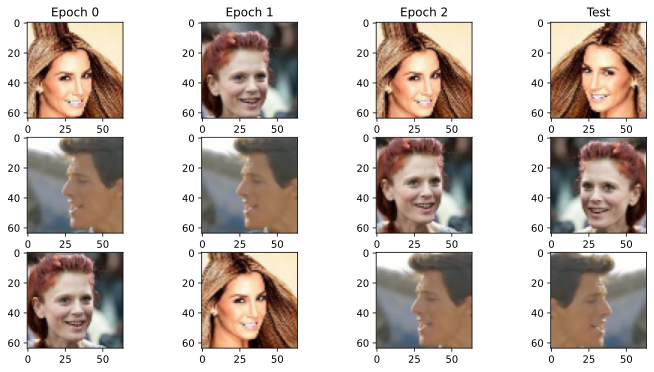

In [23]:
# In this demo, we likewise create loaders outside of train loops
train_demo = create_image_dataset(face_file_list[:3])
train_demo = train_demo.shuffle(1000)                           # order important! 
train_demo = train_demo.map(lambda x, y: (transform(x), y))     # shuffle -> map
train_demo = train_demo.batch(1)

fig, ax = plt.subplots(3, 4, figsize=(12, 6))

# Training
for epoch in range(3):
    ax[0, epoch].set_title(f"Epoch {epoch}")
    for b, batch in enumerate(train_demo):
        ax[b, epoch].imshow(batch[0][0, :, :, :])

# Inference: use same images for comparison
test_demo = create_image_dataset(face_file_list[:3])
test_demo = test_demo.map(lambda x, y: (transform(x, augment=False), y))
test_demo = test_demo.batch(1)

ax[0, 3].set_title(f"Test")
for b, batch in enumerate(test_demo):
    ax[b, 3].imshow(batch[0][0, :, :, :])

Checking if the labels are balanced so we can use accuracy metric:

In [24]:
print(r"Fraction smile:")
name = ['train', 'valid', 'test']
for i, ds in enumerate([train_ds, valid_ds, test_ds]):
    X, y = list(ds.batch(16000).as_numpy_iterator())[0]
    print(f"  {name[i]:5s}   {y.mean()*100:.1f}%")

Fraction smile:
  train   48.1%
  valid   46.5%
  test    45.7%


### Global average pooling

Now that we have our data loaders, let us look at the model architecture that we will use for smile classification. The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using 3 × 3 same convolutions, 2 × 2 nonoverlapping max-pooling blocks. Batch normalization layers are also included for regularization.

In [25]:
model = kr.Sequential([
    kr.layers.Conv2D(filters=32, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=64, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=128, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.MaxPool2D(strides=2, pool_size=2),
    
    kr.layers.Conv2D(filters=256, kernel_size=3, padding="same"),
    kr.layers.BatchNormalization(),
    kr.layers.ReLU(),
    kr.layers.GlobalAveragePooling2D(),
    
    kr.layers.Flatten(),
    kr.layers.Dense(units=2, activation='softmax')
])

model.build(input_shape=(None, 64, 64, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)      

At the final convolutional layer, we have 256 many 8 × 8 feature maps. Flattening this into a 256 × 8 × 8 = 16,384 long vector results in the loss of learned semantic structure. Not to mention the excess in capacity of the dense layer that takes this vector as input.

An alternative that we use here is a **global average-pooling** (GAP) layer which averages all pixels in the 8 × 8 feature map into a single pixel. Averaging over the spatial dimensions can make the model more robust to small spatial translations in the input. But more importantly, compressing the spatial dimension allows us to preserve the channel structure, while reducing the output to a vector of length 256. This vector can then be passed to a dense layer to perform classification. 

**Remark.** If the activations are nonnegative, each channel is forced to learn activation patterns, i.e. patterns in the kernel that result in activation, and averaging just summarizes how much the input matches this pattern. In fact, this has been used to construct [class activation maps](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/05-tensorflow-cnn.html#class-activation-maps) (CAMs) {cite}`cams` which indicate the parts of the image that are discriminative! 

### Model training and results

Training the model with Adam with a learning rate of $10^{-3}$ and a batch size of 32.

In [26]:
model.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(),
    optimizer=kr.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = kr.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5,
    restore_best_weights=True,
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=30,
    validation_data=valid_ds.batch(256),
    callbacks=[callback],
)

Epoch 1/30


2022-09-01 19:15:41.579554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 0.6293 - accuracy: 0.6450

2022-09-01 19:16:06.250950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 26s 50ms/step - loss: 0.6292 - accuracy: 0.6451 - val_loss: 1.0350 - val_accuracy: 0.5210
Epoch 2/30
500/500 [==============================] - 26s 52ms/step - loss: 0.4976 - accuracy: 0.7626 - val_loss: 0.5265 - val_accuracy: 0.7530
Epoch 3/30
500/500 [==============================] - 27s 53ms/step - loss: 0.3988 - accuracy: 0.8193 - val_loss: 0.3806 - val_accuracy: 0.8440
Epoch 4/30
500/500 [==============================] - 25s 49ms/step - loss: 0.3447 - accuracy: 0.8476 - val_loss: 0.4242 - val_accuracy: 0.7940
Epoch 5/30
500/500 [==============================] - 25s 49ms/step - loss: 0.3258 - accuracy: 0.8575 - val_loss: 0.5005 - val_accuracy: 0.8050
Epoch 6/30
500/500 [==============================] - 24s 49ms/step - loss: 0.3047 - accuracy: 0.8674 - val_loss: 0.3326 - val_accuracy: 0.8590
Epoch 7/30
500/500 [==============================] - 25s 49ms/step - loss: 0.2849 - accuracy: 0.8776 - val_loss: 0.7478 - val_accuracy: 0.6880
Epo

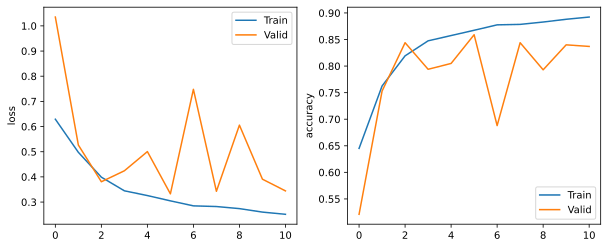

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax)

Although the validation curves look rather shaky, the minimum validation loss still moves along with the train loss as the training progresses. But here we see that the network is able to learn with only 16,000 images by using data augmentation. In fact, if we turn off data augmentation, we get extreme divergence where the model overfits early on in the training. 

Again, this makes sense: adding random transformations on the train set makes it harder for the model to memorize aspects of smile that only exist in how the training data is presented, e.g. looking at smiles in the lower center of images. At the same time, the model learns to pick up representations that are invariant to these random perturbations in the inputs.

In [28]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(64), verbose=0)[1] * 100:.2f}%") # stochastic
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(64), verbose=0)[1] * 100:.2f}%")
print(f"Test  accuracy: {model.evaluate(test_ds. batch(64), verbose=0)[1] * 100:.2f}%")

Train accuracy: 85.09%
Valid accuracy: 85.90%
Test  accuracy: 84.90%


In [29]:
X_test, y_test = next(iter(test_ds.batch(1000)))
pred_proba = model.predict(X_test)[:, 1]
pred_table = pd.DataFrame({'pred': pred_proba, 'true': y_test})
pred_table.shape

 6/32 [====>.........................] - ETA: 0s

2022-09-01 19:20:29.982922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


(1000, 2)

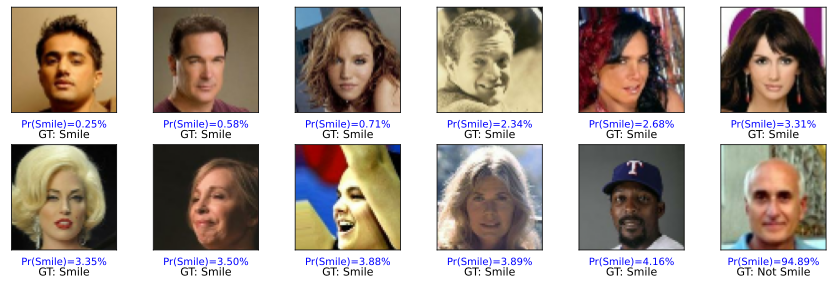

In [30]:
class_names = {
    0: 'Not Smile',
    1: 'Smile'
}

# Create distance of prediction from threshold of 0.5
pred_table['thresh_dist'] = np.abs(pred_table['pred'] - 0.5)
pred_table['correct'] = (pred_table['pred'] > 0.5) == pred_table['true']

confused = (pred_table
    .sort_values('thresh_dist', ascending=False)
    .query('correct == False')
)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    img_index = confused.index[i]
    image = X_test[img_index]
    row = confused.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where the model is confident (gives a predict probability near either 0 or 1) but also wrong. This gives us an opportunity to check whether some labels are flipped. 

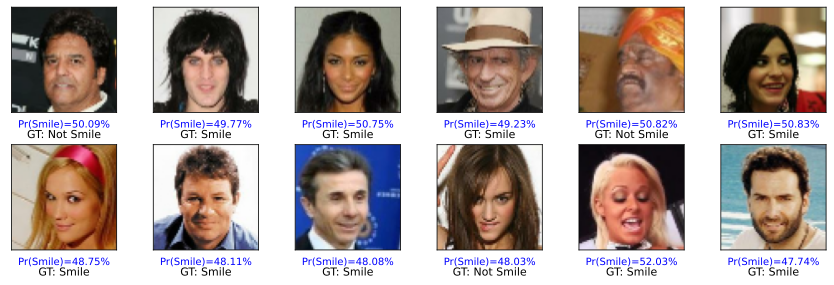

In [31]:
near_threshold = pred_table.sort_values('thresh_dist', ascending=True)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    image_index = near_threshold.index[i]
    image = X_test[image_index]
    row = near_threshold.iloc[i].to_dict()

    # Plot
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_xlabel(f"Pr(Smile)={row['pred']*100:.2f}%", color='blue')
    ax.set_title(f"GT: {class_names[row['true']]}", y=-0.3, fontsize=11)
    
fig.tight_layout()
plt.show()

**Figure.** Test examples where model is not sure of whether the face is smiling or not (it gives a predict probability that is far from either 0 or 1). Probably the fact that teeth are either occluded or absent gives the model a hard time in detecting a smile.

## Class activation maps

Previously, we introduced the concept of **class activation maps** (CAMs) {cite}`cams` in the context of GAP layers. We will try to construct this for the current model. Recall a CAM highlights the class-specific discriminative regions of an input image. So a GAP-CNN network does not only tell us what objects are present in the image, it also tells us where these objects are in the image and with no further training!

Looking at the model summary, note that the GAP layer output has 258 units. To construct the class activation maps, for each input $\boldsymbol{\mathsf x}$ we take the activations of the final ReLU layer which has shape (8, 8, 256) as **activation maps** $f_i(\boldsymbol{\mathsf x})$ of shape (8, 8) for $i = 1, \ldots, 256$ with nonnegative pixel values. Then, we take the weights ${\mathsf w}_{ij}$ of the dense layer which maps the output of the GAP layer to binary classes with label $j$ (smile or not smile), and compute the sum

$$\textsf{CAM}(\boldsymbol{\mathsf x}, j) = \sum_{i=1}^{256} f_i(\boldsymbol{\mathsf x})\,{\mathsf w}_{ij}.$$

The resulting image is (8, 8) which we can resize for better resolution. Then we overlay this on the input image $\boldsymbol{\mathsf x}$ resized to the same height and width. Thus, what we've done here is expand the linear combination of zero-dimensional average activation values to a linear combination of 2-dimensional activation maps. CAMs are implemented in the following code block for test examples.

Note that class scores are obtained by a linear combination of the average pixel values in each activation map. Since spatial ordering is preserved by convolutional layers, then the activations should indicate which pixels in the input that is in its receptive field triggered the activation, i.e. whose local representation matched the pattern in the kernel. Moreover, since the activation maps have positive pixel values, we can use the weights in the linear combination as a measure of importance for each activation for a given class.

<br>

```{figure} ../../img/cams.png
---
width: 50em
---
Global average pooling flattens the output of the convolutional base network. The outputs of the GAP layer are passed to a dense network with output dimension equal to the number of classes. It's learned weight is interpreted as importance and is used to construct maps which highlight class-specific discriminative regions. {cite}`cams`
```

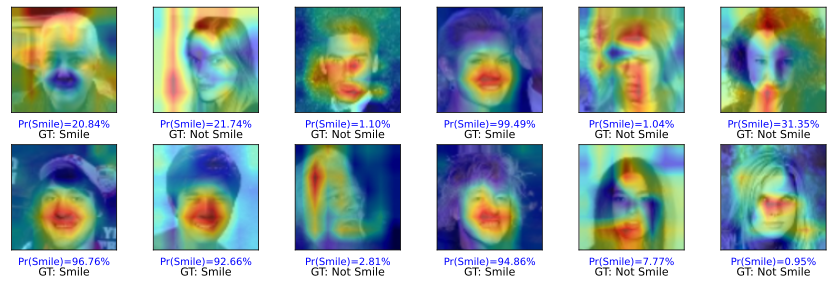

In [32]:
from functools import reduce

def plot_cam(batch, height=96, width=96):
    """Plot class activation maps (CAM) for each image in batch.
    The CAM will be taken with respect to the predicted label."""

    X, Y = batch
    class_label = {0: 'Not Smile', 1: 'Smile'}
    class_weight = model.layers[-1].get_weights()[0] # (256, m) where m = 2 (# classes)
    resize = kr.layers.Resizing(height, width)
    fig, ax = plt.subplots(2, 6, figsize=(12, 4))

    for b in range(12):
        x = X[b, :, :, :][None, :, :, :]
        t = tf.argmax(model(x), axis=1)[0]

        # Apply layers up to final conv. activation. (1, 8, 8, 256) -> (64, 256)
        act_map = tf.reshape(reduce(lambda x, f: f(x), model.layers[:-4], x), (-1, 256))
        weights = class_weight[:, t][:, None]
        cam = act_map @ weights
        cam = resize(tf.reshape(cam, (8, 8, 1)))
        
        y = Y[b]
        ax[divmod(b, 6)].imshow(resize(x[0]))
        ax[divmod(b, 6)].imshow(cam, alpha=0.7, cmap='jet')
        ax[divmod(b, 6)].set_xlabel(f"Pr(Smile)={model(x)[0, 1]*100:.2f}%", color='blue')
        ax[divmod(b, 6)].set_title(f"GT: {class_label[y.numpy()]}", y=-0.3, fontsize=11)
        ax[divmod(b, 6)].set_xticks([])
        ax[divmod(b, 6)].set_yticks([])

    fig.tight_layout()


plot_cam(batch=next(iter(test_ds.batch(12)))) # Detect smile

**Figure.** CAMs of test images for the *predicted* class (model has no access to ground truth). Regions colored red indicate high activation values. From the point of view of the model, these regions contain highly discriminative features. Notice that the model focuses around the mouth and face area whenever it has high confidence.

## Transfer learning

**Transfer learning** consists of taking weights, and hence feature representations, learned on one problem, and leveraging them on a new, similar problem. In the following experiment, we will use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) {cite}`mobilenet` model pretrained on ImageNet. This has around 2.3 million parameters and was designed to have fast inference times for resource constrained environments. This section follows the Keras guide [*Transfer learning & fine-tuning*](https://keras.io/guides/transfer_learning/). 


```{margin}
**Figure 8.12** in {cite}`keras2`
``` 
```{figure} ../../img/transfer-learning.png
---
width: 40em
---
Replacing with a new classifiers while keeping the same convolutional base.
```

Observe that the convolutional networks we encountered consist of two subnetworks: a convolutional base, that acts as a feature extractor, and a classifier on top of the base network that processes the extracted features to get class probabilities. The idea behind transfer learning is that we can take the convolutional base, that is extensively trained on a large dataset, and use its learned representations to train a new classifier on a similar task. This leads us to the following workflow:

 1. Instantiate a base model and load pre-trained weights into it.
 2. Freeze all layers in the base model by setting its `trainable` attribute to `False`.
 4. Add new layers on top of the base model.
 5. Train your new model on your new dataset.

An alternative workflow is to pass the input data *once* to the base model to get feature vectors. These vectors are then used to train a new, smaller model. This is cheaper, but we cannot use it along with data augmentation which transforms input data at each training iteration.

In [33]:
base_model = kr.applications.MobileNetV2(
    weights='imagenet',         # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),    # We will have to resize for our 64x64x3 train dataset.
    include_top=False           # Do not include the ImageNet classifier at the top.
)

# Freeze the weights
base_model.trainable = False

# Stack a classification subnetwork on top of base model
inputs = kr.Input(shape=(64, 64, 3))
x = kr.layers.Resizing(96, 96)(inputs)
x = base_model(x, training=False)            # Inference mode! ⚠⚠⚠
x = kr.layers.GlobalAveragePooling2D()(x)    # 3x3x1280 -> 1x1x1280. Remove for performance. 
x = kr.layers.Flatten()(x)
x = kr.layers.Dense(256, activation='relu')(x)
x = kr.layers.Dropout(0.5)(x)
outputs = kr.layers.Dense(1)(x)

model = kr.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               327936

**Remark.** Instantiating the base model in inference mode is important as discussed in the following section.

In [34]:
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Fit model with data augmentation
hist = model.fit(
    train_ds.batch(32),
    epochs=20,
    validation_data=valid_ds.batch(256)
)

Epoch 1/20


2022-09-01 19:20:36.448405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.5879 - binary_accuracy: 0.6849

2022-09-01 19:21:08.191539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 35s 66ms/step - loss: 0.5879 - binary_accuracy: 0.6849 - val_loss: 0.5594 - val_binary_accuracy: 0.7320
Epoch 2/20
500/500 [==============================] - 31s 61ms/step - loss: 0.5302 - binary_accuracy: 0.7252 - val_loss: 0.5451 - val_binary_accuracy: 0.7310
Epoch 3/20
500/500 [==============================] - 31s 62ms/step - loss: 0.5115 - binary_accuracy: 0.7354 - val_loss: 0.5235 - val_binary_accuracy: 0.7310
Epoch 4/20
500/500 [==============================] - 33s 64ms/step - loss: 0.5028 - binary_accuracy: 0.7419 - val_loss: 0.5152 - val_binary_accuracy: 0.7420
Epoch 5/20
500/500 [==============================] - 31s 61ms/step - loss: 0.4951 - binary_accuracy: 0.7447 - val_loss: 0.5248 - val_binary_accuracy: 0.7420
Epoch 6/20
500/500 [==============================] - 30s 61ms/step - loss: 0.4891 - binary_accuracy: 0.7500 - val_loss: 0.5162 - val_binary_accuracy: 0.7310
Epoch 7/20
500/500 [==============================] - 30s 61ms/

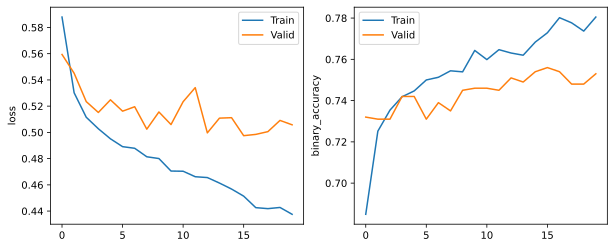

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

In [36]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(64), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(64), verbose=0)[1] * 100:.2f}%")
print(f"Test accuracy:  {model.evaluate(test_ds .batch(64), verbose=0)[1] * 100:.2f}%")

Train accuracy: 80.24%
Valid accuracy: 75.30%
Test accuracy:  74.80%


### Fine-tuning

A last optional step is **fine-tuning** which consists of unfreezing the pre-trained model, or part of it, on the new task with very low learning rate. This can potentially achieve meaningful improvements. But could also potentially lead to quick overfitting due to the potentially large number of parameters in the base model which is why we use a small learning rate. 

Note that it is critical to fine-tune a model only after the model with frozen layers has been trained to convergence. Mixing pretrained layers with randomly initialized layers will destroy the pretrained weights due to large gradient updates during the early stages of training.

In [37]:
# Unfreeze the base model.
base_model.trainable = True

# Recompile to take unfreezing into account.
model.compile(
    optimizer=kr.optimizers.Adam(1e-5),  # Very low learning rate
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[kr.metrics.BinaryAccuracy()]
)

# Stop before it overfits!
callback = kr.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Batch normalization still runs in inference mode. (See appendix.)
epochs = 10
hist = model.fit(
    train_ds.batch(32), 
    epochs=epochs, 
    validation_data=valid_ds.batch(256),
    callbacks=[callback]
)

Epoch 1/10


2022-09-01 19:32:13.561102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 0.3949 - binary_accuracy: 0.8075

2022-09-01 19:33:14.892513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 65s 123ms/step - loss: 0.3949 - binary_accuracy: 0.8075 - val_loss: 0.4460 - val_binary_accuracy: 0.8140
Epoch 2/10
500/500 [==============================] - 67s 133ms/step - loss: 0.3376 - binary_accuracy: 0.8438 - val_loss: 0.3480 - val_binary_accuracy: 0.8580
Epoch 3/10
500/500 [==============================] - 76s 152ms/step - loss: 0.2937 - binary_accuracy: 0.8642 - val_loss: 0.3276 - val_binary_accuracy: 0.8550
Epoch 4/10
500/500 [==============================] - 79s 156ms/step - loss: 0.2658 - binary_accuracy: 0.8789 - val_loss: 0.2952 - val_binary_accuracy: 0.8730
Epoch 5/10
500/500 [==============================] - 78s 155ms/step - loss: 0.2453 - binary_accuracy: 0.8875 - val_loss: 0.3010 - val_binary_accuracy: 0.8740
Epoch 6/10
500/500 [==============================] - 77s 154ms/step - loss: 0.2319 - binary_accuracy: 0.8944 - val_loss: 0.2974 - val_binary_accuracy: 0.8710
Epoch 7/10
500/500 [==============================] - 77s

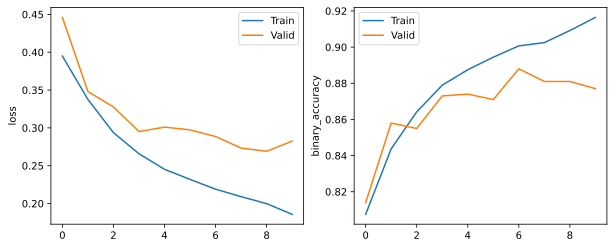

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_model_history(history=hist, ax=ax, metric='binary_accuracy')

As expected, the model is starting to overfit due to overcapacity (the train-valid loss gap is widening). And we were not able to obtain a better test scores with fine-tuning (see below). It would be nice if we had better results with transfer learning (before fine-tuning), but this is likely due to hardware limitations. For more powerful systems, we expect better performing networks with transfer learning.

In [39]:
print(f"Train accuracy: {model.evaluate(train_ds.batch(64), verbose=0)[1] * 100:.2f}%")
print(f"Valid accuracy: {model.evaluate(valid_ds.batch(64), verbose=0)[1] * 100:.2f}%")
print(f"Test  accuracy: {model.evaluate(test_ds .batch(64), verbose=0)[1] * 100:.2f}%")

Train accuracy: 91.74%
Valid accuracy: 87.70%
Test  accuracy: 87.40%


### Appendix: Batch norm

Freezing weights make batch norm layers run in inference mode that is not overridden by running the external model in training mode. This means the batch norm statistics will not update during transfer learning. Note that while `trainable` and `training` are orthogonal concepts, this default behavior makes sense since the trainable parameters in the batch norm layers of the base model are fixed. To check this we define a function that prints the sum of batch norm statistics before and after a call in training mode.

In [67]:
def simulate_train(model):
    print(tf.reduce_sum(model.layers[1].weights[2]).numpy())
    model(tf.random.normal([1, 2]), training=True)
    print(tf.reduce_sum(model.layers[1].weights[2]).numpy())

Recall that the **standard recipe** for transfer learning is to instantiate `base_model` in inference mode. Results below also show that this will not be overridden by running the external model in train mode, so that the layers of the base model will continue to run in inference mode even when we unfreeze the weights during fine-tuning. This prevents updates on non-trainable weights which are not scaled by the learning rate and may suddenly destroy what the model has learned during transfer learning.

In [68]:
# (1a) Freezing weights => BN inference mode.
base_model = kr.layers.BatchNormalization()
base_model.trainable = False

# (1b) Initializing base model in inference mode
x = kr.Input(shape=(2,))
y = base_model(x, training=False)
model = kr.Model(x, y)

print("Simulating transfer learning:")
simulate_train(model)

# (2) Unfreezing base model weights for fine-tuning
print("\nSimulating fine-tuning:")
base_model.trainable = True
simulate_train(model)

Simulating transfer learning:
0.0
0.0

Simulating fine-tuning:
0.0
0.0
